In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import pickle
from copy import deepcopy
import CBcm

In [2]:
from scipy import stats

import iminuit

In [3]:
sys.path.append('/home/jp/projects/atm_nu/mceq_tysak/muon_fit/modules')

In [4]:
common_settings = pickle.load(open('/home/jp/projects/atm_nu/ddm_results/final_settings/common_settings_daemon.pkl'))

In [5]:
import mufit
reload(mufit)
import mufit_plots as mfp
reload(mfp)

MUFIT: Using quickflux2!
MUFIT: Using quickflux2!
MufitPlots does not use the mceq flux evaluator directly
MufitPlots does not use the mceq flux evaluator directly


<module 'mufit_plots' from '/home/jp/projects/atm_nu/mceq_tysak/muon_fit/modules/mufit_plots.pyc'>

In [6]:
fitname = 'prd22_daemon_l3csyst_v1'
filename = '/home/jp/projects/atm_nu/ddm_results/'+fitname+'.pkl'

old_fitname = 'prd22_daemon_v3'
old_filename = '/home/jp/projects/atm_nu/ddm_results/'+old_fitname+'.pkl'

In [7]:
fit = mufit.MuFit(datasets = ['bessfull'                              ],

                 flux_splines = 'daemon-v3',)


/home/jp/projects/atm_nu/mceq_tysak/muon_fit/modules/resources/daemonsplines_20230207_nousertab.pkl
Excluded params removed from known_params.
No calibration file for daemon-v3
Adjusting DEIS name
daemon-v3
('Using errors in mode: ', 'mixed')


In [8]:
physics_params = common_settings['physics_params']

In [17]:
my_flux_parameters = {}
for onep in physics_params:
    if 'GSF' in onep:
        my_flux_parameters[onep] = [0., False, -4, 4, 0., 1]
    elif ('31G' in onep) or ('158G' in onep):
        my_flux_parameters[onep] = [0., False, -10, 10, 0., 1]
    elif ('20T' in onep) or ('2P' in onep):
        if 'pi+' in onep:
            my_flux_parameters[onep] = [0, False, -5., 5.,  0.,  2.]
        elif 'pi-' in onep:
            my_flux_parameters[onep] = [0,False, -33,  33,    0,  10]
        elif 'K+' in onep:
            my_flux_parameters[onep]= [ 0., False, -19,  19,  0,  10]
        elif 'K-' in onep:
            my_flux_parameters[onep]=[0., False, -25,  30, 10.,  20.]
        elif 'p' in onep:
            my_flux_parameters[onep]=[0., False, -16, 16,  0., 6]
        elif 'n' in onep:
            my_flux_parameters[onep]=[0., False, -6, 6,   0,  2.5]
#for onep in physics_params:
#    print(onep, my_flux_parameters[onep])
    
mysyst = deepcopy(fit.systematics)
mysyst.update({# Fixing DEIS because errors are included by default
               'deis_mscat':  [0.0, True, -3, 3],
               'deis_bfield':  [0.0, True, -3, 3],
               'deis_norm':  [0.0, True, -3, 3],

               # L3c (all)
               'l3c_align': 1, #np.random.uniform(-3,3),
               'l3c_bfield': 0, #np.random.uniform(-3,3),
               'l3c_eloss': 0, #np.random.uniform(-3,3),
               'l3c_overb': 0., #np.random.uniform(-3,3),
               'l3c_normHor': 0., #np.random.uniform(-3,3),
               'l3c_normVert': 0., #np.random.uniform(-3,3),
               'l3c_pres': 0., #np.random.uniform(-3,3),

               'mn_escale': 0., #np.random.uniform(-3,3),

               # Bess
               'bess_align': -1., #np.random.uniform(-3,3),
               'bess_finres': 0., #np.random.uniform(-3,3),
               })

In [18]:
nfits = 1
counter = 0
bestfit = 1E9
defprior = 60
for ifit in range(nfits):
    print 'Internal fit ', ifit
    
    # Start at best fit from previous fit
    if bestfit<1E9:
        for onekey in my_flux_parameters:
            my_flux_parameters[onekey][0] = fit.results['params'][onekey]['value']
        for onekey in mysyst:
            if type(mysyst[onekey]) == list:
                mysyst[onekey][0] = fit.results['params'][onekey]['value']    
            else:
                mysyst[onekey] = fit.results['params'][onekey]['value']  
            
#     # Change some parameters slightly
#     for i in range(4):
#         randkey = my_flux_parameters.keys()[np.random.randint(len(my_flux_parameters))]
#         my_flux_parameters[randkey][0] += np.random.normal()
    
    #print(my_flux_parameters)
    
    one_m, one_f = fit.run_fit(
        flux_parameters = my_flux_parameters,        
        exp_parameters = mysyst,
        fit_data = 'all',
        fit_mode = 'physics',
        use_priors = True,
        print_mode = False,
        dry_run = True,
        emin=5.,
        emax=1E9,
        fake_data = False,
        )
    

Internal fit  0
MuFit // Dry Run
('Chi2', 321.23453110440266)


In [19]:
exp = fit.explist['bessfull']

In [26]:
angle = '18.1949'
angle = '8.1096'

Text(0,0.5,'Error')

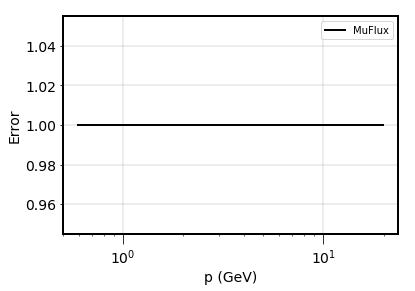

In [27]:
plt.plot(exp.data_flux[angle][0], exp.model_flux[angle]/exp.model_flux_prefit[angle], label = 'MuFlux')
plt.xscale('log')
plt.legend(loc=0)
plt.xlabel('p (GeV)')
plt.ylabel('Error')

(10, 400)

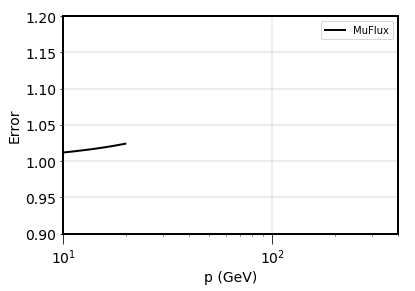

In [28]:
plt.plot(exp.data_ratio[angle][0], exp.model_ratio[angle]/exp.model_ratio_prefit[angle], label = 'MuFlux')
plt.xscale('log')
plt.legend(loc=0)
plt.xlabel('p (GeV)')
plt.ylabel('Error')
plt.ylim(0.9, 1.2)
plt.xlim(10, 400)

## Do not touch figures below, need to overwrite prefit stuff to get them

Text(0,0.5,'Error')

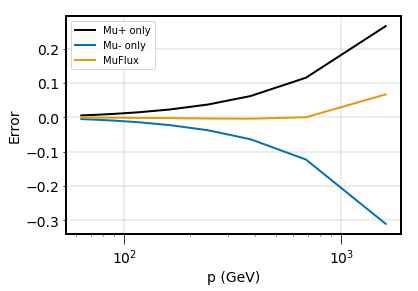

In [32]:
plt.plot(exp.data_flux[angle][0],  exp.model_flux_mup_prefit[angle]/exp.model_flux_mup[angle]-1, label='Mu+ only')
plt.plot(exp.data_flux[angle][0],  exp.model_flux_mum_prefit[angle]/exp.model_flux_mum[angle]-1, label='Mu- only')
plt.plot(exp.data_flux[angle][0], model_eval/model_prefit-1, label = 'MuFlux')
plt.xscale('log')
plt.legend(loc=0)
plt.xlabel('p (GeV)')
plt.ylabel('Error')

Text(0,0.5,'Error')

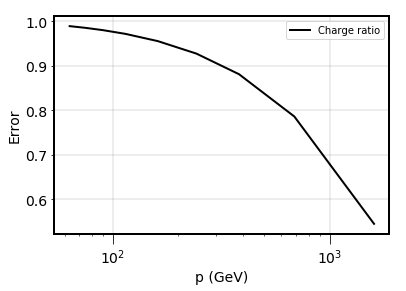

In [35]:
original_qratio = exp.model_flux_mup_prefit[angle]/exp.model_flux_mum_prefit[angle]
mod_qratio = exp.model_flux_mup[angle]/exp.model_flux_mum[angle]
plt.plot(exp.data_flux[angle][0],mod_qratio/original_qratio, label='Charge ratio')
plt.xscale('log')
plt.legend(loc=0)
plt.xlabel('p (GeV)')
plt.ylabel('Error')